In [39]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pde
from pde import PDE, ScalarField, UnitGrid
from StatTools import *
from scipy.signal import savgol_filter

nz     = 50   # set this to the number of scalar levels in CM1 sim
ens    = 35    # set this to the number of profiles you need

# set some constants used for KPZ equation

length = 120  # length of the series for KPZ

dt = 0.025    # if the solver is blowing up, try 0.02, 0.01

# mostly leave these alone, they control the PDE and I have not found a ton of sensitivity.

nu    = 1.0    
lamb  = 1.0
noise = 1.0

# Savgol filter parameters
window_size = 13
poly_order = 3

# Random number seed for reproducible results

ran_seed = 73450203

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Kardar-Parisi-Zhang (KPZ) equation

$$\frac{\partial h}{\partial t} = \nu \nabla^2h+\lambda \big( \nabla h \big)^2 + \eta(x,t)$$

where $h$ is the perturbation and $\eta(x,t)$ is a random forcing.  Here in our application it is white  Gaussian  random  noise  with  unit  variance. The KPZ equation is a stochastic PDE that can be used to generate random perturbations.  Zupanski et al. (2005, hereafter Z05) demonstrated the use of this for generating random noise to assist in the assimilation of observations in a 2D shallow water system. After generating a 1D or 2D field, Z05 then smoothed the resulting series to impose a decorrelation length scale, via spatial filtering, onto the field.  

The python package Py-PDE has several built-in PDEs, with KPZ being one of them.  Here we use the built in solution to generate a set of profiles to be used to perturb vertical wind profiles in idealized data assimilation experiments using CM1 and DART.  We use default values used in Z05 to first generate an ensemble of perturbations.

---

  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-0, non-dimensional correlation length: 34


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-1, non-dimensional correlation length: 39


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-2, non-dimensional correlation length: 61


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-3, non-dimensional correlation length: 74


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-4, non-dimensional correlation length: 65


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-5, non-dimensional correlation length: 57


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-6, non-dimensional correlation length: 52


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-7, non-dimensional correlation length: 67


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-8, non-dimensional correlation length: 56


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-9, non-dimensional correlation length: 53


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-10, non-dimensional correlation length: 55


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-11, non-dimensional correlation length: 50


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-12, non-dimensional correlation length: 68


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-13, non-dimensional correlation length: 63


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-14, non-dimensional correlation length: 40


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-15, non-dimensional correlation length: 56


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-16, non-dimensional correlation length: 75


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-17, non-dimensional correlation length: 62


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-18, non-dimensional correlation length: 37


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-19, non-dimensional correlation length: 63


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-20, non-dimensional correlation length: 66


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-21, non-dimensional correlation length: 60


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-22, non-dimensional correlation length: 66


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-23, non-dimensional correlation length: 54


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-24, non-dimensional correlation length: 42


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-25, non-dimensional correlation length: 35


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-26, non-dimensional correlation length: 76


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-27, non-dimensional correlation length: 51


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-28, non-dimensional correlation length: 61


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-29, non-dimensional correlation length: 14


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-30, non-dimensional correlation length: 60


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-31, non-dimensional correlation length: 62


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-32, non-dimensional correlation length: 59


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-33, non-dimensional correlation length: 59


  0%|          | 0/10.0 [00:00<?, ?it/s]

Profile-34, non-dimensional correlation length: 65

Pearson correlation between profile 0 and profile 1: 0.050838 
Pearson correlation between profile 0 and profile 2: 0.016648 
Pearson correlation between profile 1 and profile 2: -0.017272 



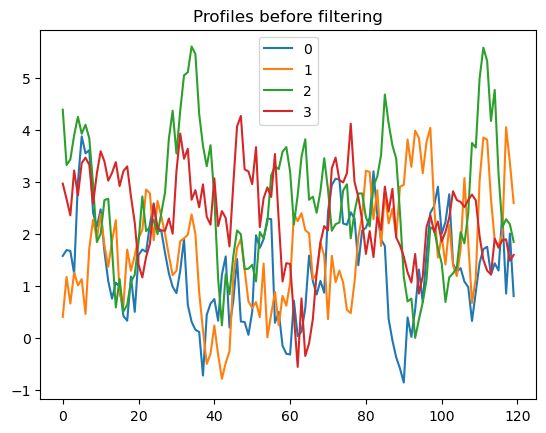

In [44]:
# KPZ

# For this to be repeatable, one needs to set the seed for both the internal py-PDE code and the numpy seed.

rand = pde.tools.numba.random_seed(ran_seed)
rng = np.random.default_rng(ran_seed+3)

# Just create these objects once, and then copy in data before integrating

grid = UnitGrid([length,1], periodic=[False, False])  # generate grid
state = ScalarField(grid)     # generate initial object for integration

# create raw output array

raw_out = np.zeros((length,ens)) 

# Running a series of 1D simulation produces more variance than running the 2D all a once,
# because the PDE then integrates in 2D, which produces correlations across profiles.

for e in np.arange(ens):

    input = rng.uniform(-1.0, 1.0, (length,))   # Use RNG generator for uniform distribution

    state.data[:,0] = input  # copy this to the state.data field for integration.

    eq = pde.KPZInterfacePDE(nu=nu, lmbda=lamb, bc={"x": 'auto_periodic_neumann', "y": 'auto_periodic_neumann'}, noise=noise)
    
    raw_out[:,e] = eq.solve(state, t_range=10, dt=dt).data[:,0]
    
    if e < 4:
        plt.plot(raw_out[:,e], label="%i" %e)
    
    correlation_len = calculate_correlation_length(raw_out[:,e])
    print(f"Profile-{e}, non-dimensional correlation length: {correlation_len}")
    
plt.title('Profiles before filtering')
plt.legend()

print('\nPearson correlation between profile 0 and profile 1: %f ' % Pearson_correlation(raw_out[:,0],raw_out[:,1]))
print('Pearson correlation between profile 0 and profile 2: %f ' % Pearson_correlation(raw_out[:,0],raw_out[:,2]))
print('Pearson correlation between profile 1 and profile 2: %f \n' % Pearson_correlation(raw_out[:,1],raw_out[:,2]))

---
Next we use a filter to decorrelate the perturbations.  Its unclear exactly how this was done in Z05, but python has a nice filter called the Savitzky-Golay filter.  This filter uses a sliding window and then fits a Nth-order polynomial to the data points.  This acts as a low-pass filter.  See __[this description](https://bartwronski.com/2021/11/03/study-of-smoothing-filters-savitzky-golay-filters/)__.  We also remove the mean from each profile and normalize the variance to 1.  Then print out the decorrelation length scale, and also the Pearson correlation between a few profiles.

---


Non-dimensional correlation Length scale for profile-0: 7

Non-dimensional correlation Length scale for profile-1: 8

Non-dimensional correlation Length scale for profile-2: 6

Non-dimensional correlation Length scale for profile-3: 6

Non-dimensional correlation Length scale for profile-4: 6

Non-dimensional correlation Length scale for profile-5: 5

Non-dimensional correlation Length scale for profile-6: 7

Non-dimensional correlation Length scale for profile-7: 5

Non-dimensional correlation Length scale for profile-8: 7

Non-dimensional correlation Length scale for profile-9: 5

Non-dimensional correlation Length scale for profile-10: 15

Non-dimensional correlation Length scale for profile-11: 6

Non-dimensional correlation Length scale for profile-12: 5

Non-dimensional correlation Length scale for profile-13: 6

Non-dimensional correlation Length scale for profile-14: 9

Non-dimensional correlation Length scale for profile-15: 9

Non-dimensional correlation Length scale for pro

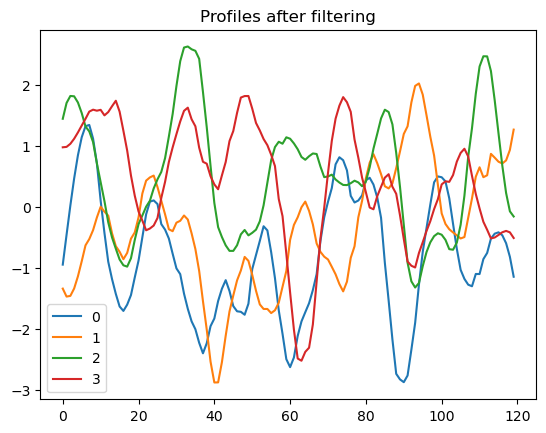

In [45]:
# Savitzky-Golay filter

filter_out = savgol_filter(raw_out, window_size, poly_order, axis=0)

# set mean to zero

filter_out = filter_out - filter_out.mean()

filter_std = 1.0 / filter_out.std(axis=0)

for e in np.arange(ens):
    filter_out[:,e] = filter_out[:,e] * filter_std[e]

    correlation_len = calculate_correlation_length(filter_out[:,e])
    print('\nNon-dimensional correlation Length scale for profile-%i: %i' % (e,  correlation_len))

    if e < 4:
        plt.plot(filter_out[:,e], label="%i" %e)

plt.title('Profiles after filtering')
plt.legend()

print('\nPearson correlation between profile 0 and profile 1: %f ' % Pearson_correlation(filter_out[:,0],filter_out[:,1]))
print('Pearson correlation between profile 0 and profile 2: %f ' % Pearson_correlation(filter_out[:,0],filter_out[:,2]))
print('Pearson correlation between profile 1 and profile 2: %f \n' % Pearson_correlation(filter_out[:,1],filter_out[:,2]))

---

For output, we obtain U & V perturbations from each END of the profiles.  The U-perts are from 0:nz-1, and V:perts are from length-nz:length-1

Write them out to a text file labeled with the profile integer

---

In [46]:
# We created a vector that at least 2x larger than the input vertical sounding (length >= 2 * nz), so split the profiles so that
# U & V are created.

for n in np.arange(ens):
    with open('wind_perts_%2.2i.txt' % (n+1), 'w') as f:
        upert = filter_out[0:nz,n]
        vpert = filter_out[-1-nz:-1,n]
        for i in np.arange(nz):
            f.write("%2.2i  %10.4f  %10.4f \n" % (i, upert[i], vpert[i]))
